# UWMGI: U-Net Keras [Train] with EDA


### Please if this kernel is useful, <font color='red'>please upvote !!</font>

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import cv2
from PIL import Image 
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.notebook import tqdm
from datetime import datetime
import json,itertools
from typing import Optional
from glob import glob

from sklearn.model_selection import StratifiedKFold

from tensorflow import keras
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint
from keras.models import load_model

import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl

In [ ]:
BATCH_SIZE = 16
EPOCHS=25
n_splits=5
fold_selected=1 # 1..5

In [ ]:
df = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/train.csv')
print(df.shape)

In [ ]:
df.rename(columns = {'class':'class_name'}, inplace = True)
#--------------------------------------------------------------------------
df["case"] = df["id"].apply(lambda x: int(x.split("_")[0].replace("case", "")))
df["day"] = df["id"].apply(lambda x: int(x.split("_")[1].replace("day", "")))
df["slice"] = df["id"].apply(lambda x: x.split("_")[3])
#--------------------------------------------------------------------------
TRAIN_DIR="../input/uw-madison-gi-tract-image-segmentation/train"
all_train_images = glob(os.path.join(TRAIN_DIR, "**", "*.png"), recursive=True)
x = all_train_images[0].rsplit("/", 4)[0] ## ../input/uw-madison-gi-tract-image-segmentation/train

path_partial_list = []
for i in range(0, df.shape[0]):
    path_partial_list.append(os.path.join(x,
                          "case"+str(df["case"].values[i]),
                          "case"+str(df["case"].values[i])+"_"+ "day"+str(df["day"].values[i]),
                          "scans",
                          "slice_"+str(df["slice"].values[i])))
df["path_partial"] = path_partial_list
#--------------------------------------------------------------------------
path_partial_list = []
for i in range(0, len(all_train_images)):
    path_partial_list.append(str(all_train_images[i].rsplit("_",4)[0]))
    
tmp_df = pd.DataFrame()
tmp_df['path_partial'] = path_partial_list
tmp_df['path'] = all_train_images

#--------------------------------------------------------------------------
df = df.merge(tmp_df, on="path_partial").drop(columns=["path_partial"])
#--------------------------------------------------------------------------
df["width"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[1]))
df["height"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[2]))
#--------------------------------------------------------------------------
del x,path_partial_list,tmp_df
#--------------------------------------------------------------------------
df.head(5)

In [ ]:
# RESTRUCTURE  DATAFRAME
df_train = pd.DataFrame({'id':df['id'][::3]})

df_train['large_bowel'] = df['segmentation'][::3].values
df_train['small_bowel'] = df['segmentation'][1::3].values
df_train['stomach'] = df['segmentation'][2::3].values

df_train['path'] = df['path'][::3].values
df_train['case'] = df['case'][::3].values
df_train['day'] = df['day'][::3].values
df_train['slice'] = df['slice'][::3].values
df_train['width'] = df['width'][::3].values
df_train['height'] = df['height'][::3].values


df_train.reset_index(inplace=True,drop=True)
df_train.fillna('',inplace=True); 
df_train['count'] = np.sum(df_train.iloc[:,1:4]!='',axis=1).values
df_train.sample(5)

In [ ]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)


def build_masks(labels,input_shape, colors=True):
    height, width = input_shape
    if colors:
        mask = np.zeros((height, width, 3))
        for label in labels:
            mask += rle_decode(label, shape=(height,width , 3), color=np.random.rand(3))
    else:
        mask = np.zeros((height, width, 1))
        for label in labels:
            mask += rle_decode(label, shape=(height, width, 1))
    mask = mask.clip(0, 1)
    return mask


In [ ]:
import keras
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size = BATCH_SIZE, subset="train", shuffle=False):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size,128,128,3))
        y = np.empty((self.batch_size,128,128,3))
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,img_path in enumerate(self.df['path'].iloc[indexes]):
            w=self.df['width'].iloc[indexes[i]]
            h=self.df['height'].iloc[indexes[i]]
            img = self.__load_grayscale(img_path)
            X[i,] =img
            if self.subset == 'train':
                for k,j in zip([0,1,2],["large_bowel","small_bowel","stomach"]):
                    rles=self.df[j].iloc[indexes[i]]
                    masks = rle_decode(rles, shape=(h, w, 1))
                    #rles=df_train[j][df_train.index==indexes[i]]
                    #masks = build_masks(rles,(h,w), colors=False)
                    masks = cv2.resize(masks, (128, 128))
                    y[i,:,:,k] = masks
        if self.subset == 'train': return X, y
        else: return X
        
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
        dsize = (128, 128)
        img = cv2.resize(img, dsize)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)
        return img
        


# EDA

In [ ]:
plt.figure(figsize=(12,4))
bar = plt.bar([1,2,3],100*np.mean( df_train.iloc[:,1:4]!='',axis=0))
plt.title('Percent Training Images with Mask', fontsize=16)
plt.ylabel('Percent of Images'); plt.xlabel('Class Type')
plt.xticks([1,2,3])
labels=["large bowel","small bowel","stomach"]
for rect,lbl in zip(bar,labels):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/3, height,  lbl,
             ha='center', va='bottom',fontsize=16)
    plt.text(rect.get_x() + rect.get_width()/1.3, height, '%.1f %%' % height,
             ha='center', va='bottom',fontsize=13)

plt.ylim((0,50)); plt.show()

In [ ]:
# SAMPLES
Masks = list(df_train[df_train['large_bowel']!=''].sample(BATCH_SIZE).index)
Masks += list(df_train[df_train['small_bowel']!=''].sample(BATCH_SIZE*2).index)
Masks += list(df_train[df_train['stomach']!=''].sample(BATCH_SIZE*3).index)


# DATA GENERATOR
View_batches = DataGenerator(df_train[df_train.index.isin(Masks)],shuffle=True)

# Visualizing
fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(nrows=6, ncols=2)
colors = ['yellow','green','red']
labels = ["Large Bowel", "Small Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3= mpl.colors.ListedColormap(colors[2])

for i in range(6):
    images, mask = View_batches[i]
    sample_img=images[0,:,:,0]
    mask1=mask[0,:,:,0]
    mask2=mask[0,:,:,1]
    mask3=mask[0,:,:,2]
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')

    ax1 = fig.add_subplot(gs[i, 1])
    if i==0:
        ax0.set_title("Image", fontsize=15, weight='bold', y=1.02)
        ax1.set_title("Mask", fontsize=15, weight='bold', y=1.02)
        plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 14,title='Mask Labels', title_fontsize=14, edgecolor="black",  facecolor='#c5c6c7')

    l0 = ax1.imshow(sample_img, cmap='bone')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
    _ = [ax.set_axis_off() for ax in [ax0,ax1]]

    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]

# Training

In [ ]:
# SAMPLES
train_mask = list(df_train[df_train['large_bowel']!=''].index)
train_mask += list(df_train[df_train['small_bowel']!=''].index)
train_mask += list(df_train[df_train['stomach']!=''].index)

df_train=df_train[df_train.index.isin(train_mask)]     
df_train.reset_index(inplace=True,drop=True)
print(df_train.shape)

# CV

In [ ]:
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (_, val_idx) in enumerate(skf.split(X=df_train, y=df_train['case']), 1):
    df_train.loc[val_idx, 'fold'] = fold
    
df_train['fold'] = df_train['fold'].astype(np.uint8)

train_ids = df_train[df_train["fold"]!=fold_selected].index
valid_ids = df_train[df_train["fold"]==fold_selected].index

df_train.groupby('fold').size()

In [ ]:
train_generator = DataGenerator(df_train[df_train.index.isin(train_ids)],shuffle=True)
val_generator = DataGenerator(df_train[df_train.index.isin(valid_ids)])

# UNET model

In [ ]:
from keras import backend as K
from keras.losses import binary_crossentropy
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)


In [ ]:
def build_model(input_shape):
    inputs = Input(input_shape)

    c1 = Conv2D(8*2, (3, 3), activation='elu', padding='same') (inputs)
    c1 = Conv2D(8*2, (3, 3), activation='elu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16*2, (3, 3), activation='elu', padding='same') (p1)
    c2 = Conv2D(16*2, (3, 3), activation='elu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32*2, (3, 3), activation='elu', padding='same') (p2)
    c3 = Conv2D(32*2, (3, 3), activation='elu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64*2, (3, 3), activation='elu', padding='same') (p3)
    c4 = Conv2D(64*2, (3, 3), activation='elu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(64*2, (3, 3), activation='elu', padding='same') (p4)
    c5 = Conv2D(64*2, (3, 3), activation='elu', padding='same') (c5)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

    c55 = Conv2D(128*2, (3, 3), activation='elu', padding='same') (p5)
    c55 = Conv2D(128*2, (3, 3), activation='elu', padding='same') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(64*2, (3, 3), activation='elu', padding='same') (u6)
    c6 = Conv2D(64*2, (3, 3), activation='elu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32*2, (3, 3), activation='elu', padding='same') (u71)
    c61 = Conv2D(32*2, (3, 3), activation='elu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32*2, (3, 3), activation='elu', padding='same') (u7)
    c7 = Conv2D(32*2, (3, 3), activation='elu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16*2, (3, 3), activation='elu', padding='same') (u8)
    c8 = Conv2D(16*2, (3, 3), activation='elu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8*2, (3, 3), activation='elu', padding='same') (u9)
    c9 = Conv2D(8*2, (3, 3), activation='elu', padding='same') (c9)

    outputs = Conv2D(3, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=binary_crossentropy, metrics=[dice_coef,iou_coef,'accuracy']) #binary_crossentropy #bce_dice_loss
    return model
model = build_model((128, 128, 3))
model.summary()

from segmentation_models import Unet
from segmentation_models.utils import set_trainable

model = Unet('efficientnetb0',input_shape=(256, 256, 3), classes=3, activation='sigmoid',encoder_weights='imagenet')
model.compile(optimizer='adam', loss=bce_dice_loss,metrics=[dice_coef,iou_coef]) #binary_crossentropy
model.summary()

# Training model

In [ ]:
from keras.callbacks import Callback, ModelCheckpoint
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    use_multiprocessing=False,
    workers=4,
    epochs=EPOCHS
)

In [ ]:
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('history.csv')

In [ ]:
# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_dice_coef'],label='Val_dice_coef')
plt.plot(range(history.epoch[-1]+1),history.history['dice_coef'],label='Trn_dice_coef')
plt.title('DICE'); plt.xlabel('Epoch'); plt.ylabel('dice_coef');plt.legend(); 
plt.show()

In [ ]:
# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_iou_coef'],label='Val_iou_coef')
plt.plot(range(history.epoch[-1]+1),history.history['iou_coef'],label='Trn_iou_coef')
plt.title('IOU'); plt.xlabel('Epoch'); plt.ylabel('iou_coef');plt.legend(); 
plt.show()

In [ ]:
# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_loss'],label='Val_loss')
plt.plot(range(history.epoch[-1]+1),history.history['loss'],label='Trn_Loss')
plt.title('LOSS'); plt.xlabel('Epoch'); plt.ylabel('loss');plt.legend(); 
plt.show()

# Predict From Valiation Set 

In [ ]:
custom_objects = custom_objects={
    'dice_coef': dice_coef,
    'iou_coef': iou_coef,
    'bce_dice_loss': bce_dice_loss  
}
model = load_model('./model.h5', custom_objects=custom_objects)

In [ ]:
pred_batches = DataGenerator(df_train[df_train.index.isin(valid_ids[0:8])],batch_size = 1,shuffle=False)
preds = model.predict_generator(pred_batches,verbose=1)

In [ ]:
Threshold = 0.1
# Visualizing
fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(nrows=8, ncols=3)
colors = ['yellow','green','red']
labels = ["Large Bowel", "Small Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3= mpl.colors.ListedColormap(colors[2])

for i in range(8):
    images, mask = pred_batches[i]
    sample_img=images[0,:,:,0]
    mask1=mask[0,:,:,0]
    mask2=mask[0,:,:,1]
    mask3=mask[0,:,:,2]
    
    pre=preds[i]
    predict1=pre[:,:,0]
    predict2=pre[:,:,1]
    predict3=pre[:,:,2]
    
    predict1= (predict1 > Threshold).astype(np.float32)
    predict2= (predict2 > Threshold).astype(np.float32)
    predict3= (predict3 > Threshold).astype(np.float32)
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')
    ax0.set_title("Image", fontsize=12, y=1.01)
    #--------------------------
    ax1 = fig.add_subplot(gs[i, 1])
    ax1.set_title("Mask", fontsize=12,  y=1.01)
    l0 = ax1.imshow(sample_img, cmap='bone')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
    #--------------------------
    ax2 = fig.add_subplot(gs[i, 2])
    ax2.set_title("Predict", fontsize=12, y=1.01)
    l0 = ax2.imshow(sample_img, cmap='bone')
    l1 = ax2.imshow(np.ma.masked_where(predict1== False,  predict1),cmap=cmap1, alpha=1)
    l2 = ax2.imshow(np.ma.masked_where(predict2== False,  predict2),cmap=cmap2, alpha=1)
    l3 = ax2.imshow(np.ma.masked_where(predict3== False,  predict3),cmap=cmap3, alpha=1)
   

    _ = [ax.set_axis_off() for ax in [ax0,ax1,ax2]]
    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]
    plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 12,title='Mask Labels', title_fontsize=12, edgecolor="black",  facecolor='#c5c6c7')


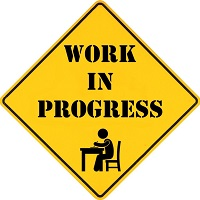